<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full bot

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install huggingface_hub[hf_xet]
!pip install --upgrade tensorflow
!pip install --upgrade bitsandbytes
!pip install --upgrade langchain_openai langchain_core langgraph SPARQLWrapper
!pip install --upgrade duckduckgo-search wikipedia wikipedia-api duckduckgo-search
!pip install --upgrade opencv-python yt-dlp pytube
!pip install --upgrade langchain_huggingface langchain_community datasets gradio
!pip install --upgrade pillow spacy librosa
!pip install sentence-transformers
!pip install langchain faiss-cpu


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s e

In [3]:
import os
import re
import tempfile
from typing import TypedDict, List, Optional, Dict, Any

import cv2
import requests
import wikipedia
from PIL import Image
import torch
import glob
import shutil

from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WikipediaLoader
from langchain_huggingface import HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage # If you are using it
from langchain_community.retrievers import BM25Retriever # If you are using it
from langgraph.prebuilt import ToolNode, tools_condition # If you are using it
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

import spacy
import yt_dlp
from io import BytesIO
from duckduckgo_search import DDGS
import librosa
from sentence_transformers import SentenceTransformer

#from tools import * # Assuming this file is in a location accessible from the current directory or you've set up the correct import path.

In [4]:
nlp = spacy.load("en_core_web_sm")


In [5]:
# API endpoint for retrieving the list of questions
url = "https://agents-course-unit4-scoring.hf.space/questions"

# Send GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

# full details
hf_questions = response.json()


[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.png'}, {'task_id': 

In [6]:
# Define file extension sets for each category
PICTURE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
AUDIO_EXTENSIONS = {'.mp3', '.wav', '.aac', '.flac', '.ogg', '.m4a', '.wma'}
CODE_EXTENSIONS = {'.py', '.js', '.java', '.cpp', '.c', '.cs', '.rb', '.go', '.php', '.html', '.css', '.ts'}
SPREADSHEET_EXTENSIONS = {
    '.xls', '.xlsx', '.xlsm', '.xlsb', '.xlt', '.xltx', '.xltm',
    '.ods', '.ots', '.csv', '.tsv', '.sxc', '.stc', '.dif', '.gsheet',
    '.numbers', '.numbers-tef', '.nmbtemplate', '.fods', '.123', '.wk1', '.wk2',
    '.wks', '.wku', '.wr1', '.gnumeric', '.gnm', '.xml', '.pmvx', '.pmdx',
    '.pmv', '.uos', '.txt'
}

def get_file_type(filename: str) -> str:
    if not filename or '.' not in filename or filename == '':
        return ''
    ext = filename.lower().rsplit('.', 1)[-1]
    dot_ext = f'.{ext}'
    if dot_ext in PICTURE_EXTENSIONS:
        return 'picture'
    elif dot_ext in AUDIO_EXTENSIONS:
        return 'audio'
    elif dot_ext in CODE_EXTENSIONS:
        return 'code'
    elif dot_ext in SPREADSHEET_EXTENSIONS:
        return 'spreadsheet'
    else:
        return 'unknown'

In [7]:
for h in hf_questions:
  print(h['question'])

How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI
Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.
Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?
Given this table defining * on the set S = {a, b, c, d, e}

|*|a|b|c|d|e|
|---|---|---|---|---|---|
|a|a|b|c|b|d|
|b|b|c|a|e|c|
|c|c|a|b|b|a|
|d|b|e|b|e|d|
|e|d|b|a|d|c|

provide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in 

In [8]:
def write_bytes_to_temp_dir(file_bytes: bytes, file_name: str) -> str:
    """
    Writes bytes to a file in the system temporary directory using the provided file_name.
    Returns the full path to the saved file.
    The file will persist until manually deleted or the OS cleans the temp directory.
    """
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_bytes)
    print(f"File written to: {file_path}")
    return file_path


In [9]:
API_URL = 'https://agents-course-unit4-scoring.hf.space/files'
for item in hf_questions:
    file_name = item.get('file_name', '')
    if file_name == '':
        item['input_file'] = None
        item['file_type'] = None
        item['file_path'] = None
    else:
        # Call the API to retrieve the file; adjust params as needed
        task_id = item['task_id']
        api_response = requests.get(f"{API_URL}/{task_id}")
        if api_response.status_code == 200:
            item['input_file'] = api_response.content  # Store file as bytes
            item['file_type'] = get_file_type(file_name)
            item['file_path'] = write_bytes_to_temp_dir(item['input_file'], file_name)
        else:
            item['input_file'] = None  # Or handle error as needed

File written to: /tmp/cca530fc-4052-43b2-b130-b30968d8aa44.png
File written to: /tmp/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
File written to: /tmp/f918266a-b3e0-4914-865d-4faa564f1aef.py
File written to: /tmp/1f975693-876d-457b-a649-393859e79bf3.mp3
File written to: /tmp/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


In [10]:
def extract_final_answer(text: str) -> str:
    """
    Returns the substring starting from the last occurrence of 'FINAL ANSWER:' (case-insensitive)
    to the end of the string. If not found, returns an empty string.
    """
    marker = "FINAL ANSWER:"
    idx = text.lower().rfind(marker.lower())
    if idx == -1:
        return ""
    return text[idx:].strip()


In [11]:
import json
import re
import gc
import uuid # For generating unique tool call IDs
from datetime import datetime
from typing import TypedDict, Annotated, List, Optional, Dict, Any, Literal

import torch
import wikipedia # For WikipediaLoader
import requests # For WikipediaLoader
from transformers import pipeline

from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter # Added
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, ToolMessage
from langchain_core.tools import BaseTool, render_text_description
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_huggingface import HuggingFacePipeline

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode # Using prebuilt tools_condition and ToolNode

# --- Model Configuration ---
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
#model_id = "Qwen/Qwen2.5-Coder-32B-Instruct" # As specified by user

# Optimize for 15GB GPU: use bfloat16, device_map="auto", and limit max_new_tokens
# If you run out of memory, try model_kwargs={"torch_dtype": torch.float16}
hf_pipe = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16, # bfloat16 is generally better if supported
    # model_kwargs={"torch_dtype": torch.float16}, # Alternative if bfloat16 causes issues or for older GPUs
    max_new_tokens=1024, # Increased for potentially longer thoughts/actions
    # You may also add: model_kwargs={"attn_implementation": "flash_attention_2"} if supported
)

llm = HuggingFacePipeline(pipeline=hf_pipe)

# Optional: For spaCy entity extraction in the standalone `extract_entities` function
# import spacy
# nlp = spacy.load("en_core_web_sm") # Load a spaCy model if you want to use it
nlp = None # Set to None if not using spaCy, so the regex fallback is used in extract_entities

# --- Agent State Definition ---
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], lambda x, y: x + y]
    # context: List[Document] # This was for the separate RAG, not directly used by re_agent state
    # tool_output: Optional[str] # ToolNode appends ToolMessages to 'messages'

# --- Memory Management Utilities ---
def get_optimal_device():
    """Get optimal device based on available memory"""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory
        # A more robust way to get free memory might be needed depending on environment
        # This is a simplification:
        try:
            # nvidia-smi like free memory
            free_memory = torch.cuda.mem_get_info()[0]
        except Exception:
            # Fallback if mem_get_info is not available or on older PyTorch
            free_memory = total_memory - torch.cuda.memory_allocated(0)

        print(f"GPU Memory: {free_memory/1024**3:.2f}GB free of {total_memory/1024**3:.2f}GB total")
        if free_memory < 2 * 1024**3: # If less than 2GB free, use CPU
            print("Warning: Low GPU memory, consider using CPU or a smaller model if OOM errors occur.")
            # return "cpu" # Option to force CPU, but device_map="auto" should handle this.
    return "cuda:0" if torch.cuda.is_available() else "cpu"

def clear_gpu_memory():
    """Clear GPU cache and run garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# --- Custom Wikipedia Tool Components ---
class WikipediaLoader:
    """
    Custom Wikipedia loader that can fetch current or specific revisions of articles.
    """
    def __init__(self, query: str, lang: str = "en", revision: Optional[int] = None,
                 load_max_docs: int = 1, doc_content_chars_max: int = 200000, # Reduced default
                 load_all_available_meta: bool = True):
        self.query = query
        self.lang = lang
        self.revision = revision # Can be a year (int) or a specific revision ID (int)
        self.load_max_docs = load_max_docs # Though typically we fetch one page per query
        self.doc_content_chars_max = doc_content_chars_max
        self.load_all_available_meta = load_all_available_meta

    def _get_revision_id_by_year(self, pageid: int, year: int) -> Optional[int]:
        """Gets the last revision ID for a given year."""
        target_date = datetime(year, 12, 31, 23, 59, 59) # End of the year
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query", "prop": "revisions", "pageids": pageid,
            "rvlimit": 1, "rvdir": "older", "rvstart": target_date.isoformat() + "Z",
            "format": "json"
        }
        try:
            response = requests.get(url, params=params, timeout=10).json()
            pages = response.get("query", {}).get("pages", {})
            page_info = pages.get(str(pageid), {})
            revisions_data = page_info.get("revisions", [])
            if revisions_data:
                return revisions_data[0].get("revid")
        except requests.RequestException as e:
            print(f"API request failed for _get_revision_id_by_year: {e}")
        except Exception as e:
            print(f"Error parsing revision ID by year: {e}")
        return None

    def _get_content_by_revision_id(self, pageid: int, rev_id: int) -> Optional[str]:
        """Gets page content for a specific revision ID."""
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query", "prop": "revisions", "revids": rev_id,
            "rvprop": "content", "formatversion": 2, "format": "json"
        }
        try:
            response = requests.get(url, params=params, timeout=10).json()
            page_data = response.get("query", {}).get("pages", [])
            if page_data and "revisions" in page_data[0]:
                content = page_data[0]["revisions"][0].get("content")
                return content
        except requests.RequestException as e:
            print(f"API request failed for _get_content_by_revision_id: {e}")
        except Exception as e:
            print(f"Error parsing content by revision ID: {e}")
        return None

    def load(self) -> List[Document]:
        wikipedia.set_lang(self.lang)
        docs = []
        try:
            # Use search to find the best page title, then get that page
            search_results = wikipedia.search(self.query, results=self.load_max_docs)
            if not search_results:
                return []

            for page_title in search_results:
                try:
                    page = wikipedia.page(title=page_title, auto_suggest=False)
                    page_id = page.pageid
                    content = None
                    revision_label = "current"

                    if isinstance(self.revision, int):
                        if len(str(self.revision)) == 4: # Assume it's a year
                            rev_id = self._get_revision_id_by_year(page_id, self.revision)
                            if rev_id:
                                content = self._get_content_by_revision_id(page_id, rev_id)
                                revision_label = f"year {self.revision} (rev_id {rev_id})"
                        else: # Assume it's a specific revision ID
                            content = self._get_content_by_revision_id(page_id, self.revision)
                            revision_label = f"rev_id {self.revision}"

                    if content is None: # Fallback to current content
                        content = page.content
                        revision_label = "current"

                    content = content[:self.doc_content_chars_max]
                    metadata = {"title": page.title, "source": page.url, "revision": revision_label}
                    if self.load_all_available_meta:
                        metadata.update({
                            "page_id": page.pageid, "summary": page.summary[:1000], # Add a summary snippet
                            "categories": page.categories[:10], # Limit categories
                        })
                    docs.append(Document(page_content=content, metadata=metadata))
                except wikipedia.exceptions.PageError:
                    print(f"Wikipedia PageError for title: {page_title}. Skipping.")
                    continue # Skip to next search result
                except wikipedia.exceptions.DisambiguationError as e:
                    print(f"Wikipedia DisambiguationError for title: {page_title}. Options: {e.options[:5]}. Skipping.")
                    continue
                except Exception as e:
                    print(f"Error processing Wikipedia page {page_title}: {e}")
                    continue
            return docs

        except Exception as e:
            print(f"Error loading Wikipedia content for query '{self.query}': {e}")
            return []

class WikipediaSearchTool(BaseTool):
    name: str = "WikipediaSearch"
    description: str = (
        "Use this tool to search Wikipedia for factual, encyclopedic information. "
        "Input should be a search query string. "
        "You can optionally specify a version year by appending ' (year YYYY)' to the query, "
        "e.g., 'Artificial Intelligence (year 2020)'."
    )

    def _parse_query_for_year(self, query: str) -> (str, Optional[int]):
        match = re.search(r"(.*?)\s*\(year\s*(\d{4})\s*\)\s*$", query, re.IGNORECASE)
        if match:
            actual_query = match.group(1).strip()
            year = int(match.group(2))
            return actual_query, year
        return query, None

    def _run(self, query: str) -> str:
        clear_gpu_memory() # Clear before potentially large text processing
        actual_query, year = self._parse_query_for_year(query)

        loader = WikipediaLoader(query=actual_query, revision=year, doc_content_chars_max=10000) # Truncate earlier
        docs = loader.load()
        clear_gpu_memory() # Clear after processing

        if not docs:
            return "No Wikipedia content found for your query."

        # Combine content from loaded docs (usually 1, but loader supports more)
        combined_content = "\n\n---\n\n".join(
            f"Title: {doc.metadata.get('title', 'N/A')}\n"
            f"Revision: {doc.metadata.get('revision', 'N/A')}\n"
            f"Content Snippet:\n{doc.page_content}"
            for doc in docs
        )
        return combined_content[:15000] # Return a significant chunk

# --- Tool Instantiation ---
search_tool = DuckDuckGoSearchRun()
wiki_tool = WikipediaSearchTool()
tools = [search_tool, wiki_tool]

# --- System Prompt for ReAct Agent ---
formatted_tools_description = render_text_description(tools)
current_date_str = datetime.now().strftime("%Y-%m-%d")

# This is the central system prompt that guides the LLM's ReAct behavior.
# It asks the LLM to output "Thought:", then "Action:" and "Action Input:", or "FINAL ANSWER:".
# The Qwen Coder model might need careful prompting to stick to this exact format.
# If it deviates, the `parse_react_output` node will fail.
system_message_template = f"""You are a helpful AI assistant with access to the following tools:

{formatted_tools_description}

To use a tool, you MUST use the following format strictly:
Thought: [Your thought process on why you need to use a tool and which one]
Action: [The exact name of the tool to use, e.g., DuckDuckGoSearch or WikipediaSearch]
Action Input: [The input string for the tool]

If you can answer the question without using a tool, or after using a tool and gathering enough information,
respond with the final answer in the format:

Thought: [Your thought process on why you have enough information]
FINAL ANSWER: [Your final answer to the user's original question]

You should only use a tool if necessary to answer the question accurately.
The current date is {current_date_str}.

Begin!
"""

# --- ReAct Graph Nodes ---

def call_llm(state: AgentState):
    """Node to call the language model."""
    clear_gpu_memory()
    messages = state['messages']

    # Add system prompt if it's the first turn or not present
    # This simple check assumes the first message should be the system prompt
    if not messages or not (isinstance(messages[0], AIMessage) and messages[0].content.startswith("You are a helpful AI assistant")):
        # This is a simplified way to ensure system prompt is at the start.
        # For more complex histories, you might need a more robust way to manage system prompt.
        # The current setup might re-add it if history is manipulated in unexpected ways.
        # A common pattern is to format a full prompt (system + history + user_input) each time.
        # However, LangGraph expects 'messages' to be the history to send.

        # For now, prepend if not there.
        # If you always want the system prompt to "frame" the latest user request,
        # you might construct a temporary list: [AIMessage(content=system_message_template)] + messages
        # But the official LangChain way is to pass it at LLM initialization or as part of the `invoke` call's `prompt` argument if the LLM wrapper supports it.
        # Since HuggingFacePipeline takes messages directly, we prepend here.

        # Let's ensure the *very first* message is the system prompt for the whole conversation
        if not any(m.content == system_message_template and isinstance(m, AIMessage) for m in messages):
             current_messages = [AIMessage(content=system_message_template)] + messages
        else:
            current_messages = messages
    else:
        current_messages = messages # System prompt seems to be there

    response = llm.invoke(current_messages) # LLM will generate text based on the history
    clear_gpu_memory()
    # The response here is an AIMessage with content being the raw string from the LLM
    return {"messages": [response]}


def parse_react_output(state: AgentState):
    """
    Parses the LLM's raw string output (expected to be in ReAct format)
    and prepares it for the ToolNode by populating 'tool_calls' if an action is found.
    """
    last_message = state['messages'][-1]
    if not isinstance(last_message, AIMessage) or not isinstance(last_message.content, str):
        return state # Should not happen if call_llm is working

    llm_output_text = last_message.content

    # Regex to find "Action: [tool_name]" and "Action Input: [input]"
    action_match = re.search(r"Action:\s*(\w+)\s*\nAction Input:\s*(.*)", llm_output_text, re.DOTALL | re.IGNORECASE)

    if action_match:
        tool_name = action_match.group(1).strip()
        tool_input_str = action_match.group(2).strip()

        # Validate if the tool_name is one of the available tools
        available_tool_names = [tool.name for tool in tools]
        if tool_name not in available_tool_names:
            # LLM might be hallucinating a tool or using a wrong name.
            # We could add a message back to LLM to correct itself, or just end.
            # For now, we'll create a ToolMessage indicating error, then it will go back to LLM.
            error_msg = f"Error: LLM tried to use an invalid tool: '{tool_name}'. Available tools: {available_tool_names}. Please choose a valid tool or provide a FINAL ANSWER."
            # To send this back to the LLM, we'd typically append a HumanMessage or a specific error message type.
            # However, ToolNode expects tool_calls. If no valid tool_calls, tools_condition routes to END or LLM.
            # Let's just not create tool_calls, and the LLM might retry or give up.
            # A better way is to format an error message and feed it back.
            # For now, let's assume the LLM will get it right or the flow will go to END via tools_condition.
            print(error_msg)
            # No tool_calls means tools_condition will likely route to "__end__" or back to LLM if configured to retry.
            # To make it robust, we should force a message back to LLM.
            # For simplicity of this example, we'll let tools_condition handle it (likely to end).
            # A more advanced implementation would add a new message to prompt the LLM to fix its action.
            last_message.content += f"\n\n(System note: Invalid tool name '{tool_name}'. Please choose from {available_tool_names} or provide FINAL ANSWER.)"
            last_message.tool_calls = [] # Ensure it's empty
            return {"messages": state['messages']}


        tool_call_id = str(uuid.uuid4())
        # ToolNode expects args as a dict. DuckDuckGoSearchRun and our Wikipedia tool take a single string.
        # So, we can use a common key like "query" or "input".
        # Let's check tool.args_schema to be more robust if tools have specific arg names.
        # For simplicity, assuming tools take a single string input that can be passed as `tool_input_str`.
        # The `ToolNode` will pass `tool_input_str` as the first arg, or if tools use Pydantic, it might try to match.
        # Most simple tools are fine with `*args`.
        # A safer way for tools with defined Pydantic schemas for args:
        # args_dict = {"input": tool_input_str} # or {"query": tool_input_str}
        # For DuckDuckGoSearchRun, the input is just the string.
        # For WikipediaSearchTool, the input is also just the string query.

        last_message.tool_calls = [{
            "name": tool_name,
            "args": tool_input_str, # Directly pass the string if tools accept single string arg
            # If tool expects dict: "args": {"query": tool_input_str} or whatever the tool's arg name is
            "id": tool_call_id
        }]
        # The original AIMessage content (thought + action string) is preserved.
        # ToolNode will use tool_calls and append ToolMessage.
        return {"messages": state['messages']}

    # If no "Action:" found, or if "FINAL ANSWER:" is present, tools_condition will handle routing.
    # tools_condition checks for non-empty tool_calls. If empty, it usually means "respond to user" (END).
    last_message.tool_calls = [] # Ensure it's empty if no valid action parsed
    return {"messages": state['messages']}


# --- Graph Construction ---
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_llm)
workflow.add_node("parser", parse_react_output) # New parser node
workflow.add_node("call_tool", ToolNode(tools)) # Using LangGraph's prebuilt ToolNode

workflow.set_entry_point("llm")

workflow.add_edge("llm", "parser") # LLM output goes to our parser

# tools_condition will check if the 'tool_calls' attribute in the last AIMessage is set by our parser.
# If set, it routes to "call_tool". Otherwise, it routes to END.
workflow.add_conditional_edges(
    "parser",
    tools_condition, # LangGraph's prebuilt condition
    # If tools_condition returns "tools", edge to "call_tool"
    # If tools_condition returns "__end__" or any other value, edge to END
    {
        "tools": "call_tool", # Key used by tools_condition when tools are present
        "__end__": END      # Key used by tools_condition when no tools (means reply or end)
    }
)
workflow.add_edge("call_tool", "llm") # Output of tool (ToolMessage) goes back to LLM

re_agent = workflow.compile()

# --- Example Invocation (Illustrative) ---
def run_agent(input_query: str):
    initial_state = AgentState(messages=[HumanMessage(content=input_query)])

    print(f"\n--- Running Agent for Query: '{input_query}' ---")

    # It's good practice to have a limit on the number of steps to prevent infinite loops
    # config={"recursion_limit": 10}
    # For streaming output:
    # async for event in re_agent.astream(initial_state, config={"recursion_limit": 10}):
    # for key, value in event.items():
    # print(f"Node: {key}")
    # if value: print(f"Output: {value['messages'][-1].pretty_repr()[:500]}")
    # print("---")
    # final_state = event.get(END, None) # Check if it's the end state

    final_result_state = None
    for step_output in re_agent.stream(initial_state, config={"recursion_limit": 10}):
        # step_output is a dictionary where keys are node names and values are their outputs
        node_name = list(step_output.keys())[0]
        node_output = step_output[node_name]
        print(f"\n<<< Executed Node: {node_name} >>>")
        if 'messages' in node_output:
            print("Messages in State:")
            for msg in node_output['messages'][-3:]: # Print last few messages for brevity
                 if isinstance(msg, AIMessage):
                     print(f"  AIMessage: {msg.content[:300]}...")
                     if msg.tool_calls: print(f"    Tool Calls: {msg.tool_calls}")
                 elif isinstance(msg, HumanMessage):
                     print(f"  HumanMessage: {msg.content[:300]}...")
                 elif isinstance(msg, ToolMessage):
                     print(f"  ToolMessage (id: {msg.tool_call_id}): {msg.content[:300]}...")
                 else:
                     print(f"  Message: {msg.content[:300]}...")
        else:
            print(f"  Output: {str(node_output)[:300]}...")

        if END in step_output:
            final_result_state = step_output[END]
            print("\nAgent run finished.")
            break
        print("--------------------------------------")

    if final_result_state and 'messages' in final_result_state:
        print("\n--- Final Answer ---")
        # The final answer should be in the last AIMessage if the agent followed the prompt
        final_ai_message = next((m for m in reversed(final_result_state['messages']) if isinstance(m, AIMessage)), None)
        if final_ai_message and "FINAL ANSWER:" in final_ai_message.content:
            print(final_ai_message.content)
        elif final_ai_message:
            print("Agent concluded, but 'FINAL ANSWER:' tag not found in last AI message. Last AI message content:")
            print(final_ai_message.content)
        else:
            print("Agent concluded, but no final AI message found.")
    elif not final_result_state:
        print("\nAgent did not reach END state (possibly hit recursion limit).")
        # You can inspect the last `step_output` here if needed

    return final_result_state

# --- Standalone RAG-like functions (from original user code, not part of `re_agent`) ---
# These functions (extract_entities, retrieve, generate) are separate from the ReAct agent above.
# They could be used to build a different kind of pipeline or be adapted into tools if needed.

def extract_entities(text: str) -> List[str]:
    """Extract key entities from text using spaCy if available, or regex fallback"""
    if nlp: # nlp object needs to be loaded: e.g., nlp = spacy.load("en_core_web_sm")
        doc = nlp(text)
        entities = [ent.text for ent in doc.ents if ent.label_ in ("PERSON", "ORG", "GPE", "PRODUCT", "EVENT", "WORK_OF_ART")]
        if not entities: # Fallback to nouns and proper nouns if no specific entities found
            keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]
            return keywords[:5] # Limit keywords
        return entities[:5]
    else:
        # Simple fallback using regex to extract potential keywords (case-insensitive)
        words = re.findall(r'\b[A-Z][a-z]*\b(?:\s+[A-Z][a-z]*)*|\b[a-zA-Z]{3,}\b', text) # Capture proper nouns or longer words
        stopwords = {"what", "who", "when", "where", "why", "how", "is", "are", "the", "a", "an", "of", "in", "on", "at", "for", "s", "t"}
        # Filter stopwords and prioritize longer words or capitalized sequences
        keywords = [word for word in words if word.lower() not in stopwords and (bool(re.match(r'[A-Z]', word)) or len(word) > 3)]
        # Deduplicate while preserving order
        seen = set()
        unique_keywords = [x for x in keywords if not (x in seen or seen.add(x))]
        return unique_keywords[:5] # Return top 5

# Note: The `retrieve_documents_for_rag` and `generate_answer_from_rag_context` functions below
# are based on your original `retrieve` and `generate` functions. They are named differently
# to avoid confusion with the ReAct agent components and to clarify their potential role in a separate RAG pipeline.

def retrieve_documents_for_rag(question: str, wiki_query: Optional[str] = None, revision_year: Optional[int] = None) -> List[Document]:
    """Retrieve and split Wikipedia content for a RAG pipeline."""
    print("Running RAG document retrieval node")
    clear_gpu_memory()

    query_for_wikipedia = wiki_query
    if not query_for_wikipedia:
        entities = extract_entities(question)
        if entities:
            query_for_wikipedia = " ".join(entities)
        else:
            query_for_wikipedia = question # Fallback to full question

    print(f"RAG Wikipedia Search Query: '{query_for_wikipedia}', Year: {revision_year}")

    try:
        loader = WikipediaLoader(
            query=query_for_wikipedia,
            revision=revision_year,
            load_max_docs=1, # Usually focus on the top document for RAG from a specific query
            doc_content_chars_max=200000
        )
        docs = loader.load()

        if not docs:
            print("No documents found by WikipediaLoader for RAG.")
            return []

        # Splitting logic for RAG
        splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk, metadata=doc.metadata) for chunk in chunks])

        print(f"RAG Retrieval: Retrieved and split into {len(all_chunks)} chunks.")
        clear_gpu_memory()
        return all_chunks

    except Exception as e:
        print(f"RAG Retrieval error: {e}")
        clear_gpu_memory()
        return []

def get_llm_pipeline_for_rag(): # Separate getter if RAG needs different LLM settings
    # For now, uses the same global pipe. Could be configured differently.
    return hf_pipe


def generate_answer_from_rag_context(question: str, context_docs: List[Document]) -> str:
    """Generate an answer based on retrieved documents for a RAG pipeline."""
    print("Running RAG answer generation node")
    clear_gpu_memory()

    if not context_docs:
        return "Error: No context documents provided for answer generation."

    try:
        docs_content = "\n\n---\n\n".join([doc.page_content for doc in context_docs[:5]]) # Limit context size

        # Simplified prompt for RAG
        prompt_str = (
            "You are an AI assistant. Based ONLY on the provided context documents, answer the following question. "
            "If the answer is not found in the context, state that explicitly.\n\n"
            f"CONTEXT DOCUMENTS:\n{docs_content}\n\n"
            f"QUESTION: {question}\n\nANSWER:"
        )

        llm_rag_pipe = get_llm_pipeline_for_rag()

        try:
            response = llm_rag_pipe(
                prompt_str,
                max_new_tokens=300, # Max tokens for the RAG answer
                temperature=0.2 # Lower temperature for factual RAG
            )
            answer_text = response[0]["generated_text"]
            # Clean up the answer: remove the prompt part if the model includes it
            if prompt_str.lower() in answer_text.lower(): # Basic check
                 answer_text = answer_text[len(prompt_str):].strip()
            elif "ANSWER:" in answer_text:
                 answer_text = answer_text.split("ANSWER:")[-1].strip()


        except torch.cuda.OutOfMemoryError:
            clear_gpu_memory()
            print("RAG Generation: OOM on GPU, falling back to CPU (this will be slow).")
            # Simplified CPU fallback for RAG
            # This part would need the same detailed model loading as in your original `generate` if used heavily.
            # For brevity, assuming it might not be hit as often or can be simplified for now.
            return "Error: GPU out of memory during RAG generation, and CPU fallback is not fully implemented here for brevity."

        clear_gpu_memory()
        return answer_text

    except Exception as e:
        print(f"Error in RAG generate node: {str(e)}")
        clear_gpu_memory()
        return f"Error generating RAG answer: {str(e)}"

# Example of how you might use the RAG functions (separate from the ReAct agent)
# if __name__ == '__main__':
#     rag_question = "What were the key developments in AI in 2020 according to Wikipedia?"
#     retrieved_rag_docs = retrieve_documents_for_rag(rag_question, revision_year=2020)
#     if retrieved_rag_docs:
#         final_rag_answer = generate_answer_from_rag_context(rag_question, retrieved_rag_docs)
#         print("\n--- RAG Pipeline Answer ---")
#         print(final_rag_answer)
#     else:
#         print("\n--- RAG Pipeline Answer ---")
#         print("Could not retrieve documents for RAG.")

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


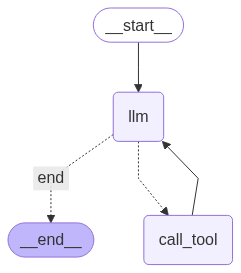

In [18]:
#from IPython.display import display
import IPython.display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

IPython.display.display(
    IPython.display.Image(
        re_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
run_agent("What was the main topic of the Wikipedia article on 'Artificial Intelligence' in the year 2020?")


--- Running Agent for Query: 'What was the main topic of the Wikipedia article on 'Artificial Intelligence' in the year 2020?' ---


KeyboardInterrupt: 

In [ ]:
rag_question = hf_questions[0]['question']
retrieved_rag_docs = retrieve_documents_for_rag(rag_question, revision_year=2022)

In [15]:
generate_answer_from_rag_context(rag_question, retrieved_rag_docs)

Running RAG answer generation node


KeyboardInterrupt: 

In [19]:
# Example: User asks a question about a recent event
user_question = "Who won the 2025 UEFA Champions League final?"

state = {
    "messages": [HumanMessage(content=user_question)],
    "tool_output": None
}

# Run the agent
result = re_agent.invoke(state)

# Print the agent's response
print(result["messages"][-1].content)

KeyboardInterrupt: 

In [ ]:

qnum = 9
s = State(question = hf_questions[qnum]['question'],
            input_file = hf_questions[qnum]['input_file'],
            file_type = hf_questions[qnum]['file_type'],
            file_path = hf_questions[qnum]['file_path'])
temp_ans = intelligent_agent(s)
final_ans = extract_final_answer(temp_ans)
print(final_ans)

Processing question: Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.
Running node_decide
Has Wikipedia reference: False
Has YouTube link: False
Has picture file: 

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Audio transcript:  In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and corn starch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie filling to cool before using it as a delicious and fruity filling for your pie crust.


<ipython-input-36-c8d09ddddd56>:558: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
print(temp_ans)

No answer found.


In [ ]:
print(temp_ans)

You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.
Context:


Question: I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy any

In [ ]:
hf_questions[0]['question']

'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.'

In [ ]:
foo

{'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.',
 'input_file': None,
 'file_type': None,
 'file_path': None,
 'context': [Document(metadata={}, page_content='Haydée Mercedes "La Negra" Sosa (Latin American Spanish: [meɾˈseðes ˈsosa]; 9 July 1935 – 4 October 2009) was an Argentine singer who was popular throughout Latin America and many countries outside the region. With her roots in Argentine folk music, Sosa became one of the preeminent exponents of El nuevo cancionero. She gave voice to songs written by many Latin American songwriters. Her music made people hail her as the "voice of the voiceless ones". She was often called "the conscience of Latin America".'),
  Document(metadata={}, page_content="Sosa performed in venues such as the Lincoln Center in New York City, the Théâtre Mogador in Paris, the Sistine Chapel in Vatican City, as well as sold-out shows in New York's

In [ ]:
len(final_ans)

24751

In [ ]:
full_ans = []
model_answers = []
reasoning_trace = []
for qnum in range(len(hf_questions)):
  s = State(question = hf_questions[qnum]['question'],
            input_file = hf_questions[qnum]['input_file'],
            file_type = hf_questions[qnum]['file_type'],
            file_path = hf_questions[qnum]['file_path'])
  print(f"s['question'] {qnum}")
  temp_ans = intelligent_agent(s)
  full_ans.append(temp_ans)
  temp_ans, reasoning = split_final_answer(temp_ans)
  model_answers.append(temp_ans)
  reasoning_trace.append(reasoning)
  print(temp_ans)


s['question'] 0
Processing question: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Running node_decide
Has Wikipedia reference: True
Has YouTube link: False
Has picture file: False
Has audio file: False
Routing to: retrieve


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Routing to: generate
Running generate


KeyboardInterrupt: 

## Older code

In [ ]:
import os
import re
import cv2
import shutil
import glob
import librosa
import numpy as np
import torch
import gc
from PIL import Image
from collections import Counter
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    pipeline
)
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langgraph.graph import StateGraph, START, END

# Set PyTorch memory management options
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

try:
    import yt_dlp
except ImportError:
    print("yt_dlp not installed. Video functionality will be limited.")

try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
except ImportError:
    print("spaCy not installed. Using regex-based entity extraction as fallback.")
    nlp = None

# Global memory management function
def clear_gpu_memory():
    """Clear GPU cache and run garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: Optional[bytes]
    file_type: Optional[str]
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node
    llm_prompt: Optional[str]  # Added to handle custom prompts between nodes

# --- Initialize models with memory management ---
def get_optimal_device():
    """Get optimal device based on available memory"""
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory
        free_memory = torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)
        print(f"GPU Memory: {free_memory/1024**3:.2f}GB free of {total_memory/1024**3:.2f}GB total")

        # If less than 2GB free, use CPU
        if free_memory < 2 * 1024**3:
            return "cpu"
        else:
            return "cuda:0"
    else:
        return "cpu"

# --- LLM pipeline with lazy initialization ---
_llm_pipe = None

# --- LLM pipeline with improved memory efficiency ---
def get_llm_pipeline():
    """Get LLM pipeline with lazy initialization and proper quantization"""
    global _llm_pipe

    if _llm_pipe is None:
        print("Initializing LLM pipeline...")
        clear_gpu_memory()

        try:
            # First try with 8-bit quantization on GPU
            if torch.cuda.is_available():
                print("Loading 8-bit quantized model on GPU")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="auto",
                    model_kwargs={
                        "load_in_8bit": True,  # Enable 8-bit quantization
                        "torch_dtype": torch.float16,
                    },
                    max_new_tokens=256
                )
                print("Successfully loaded 8-bit quantized model on GPU")
            else:
                print("No GPU available, loading model on CPU")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="cpu",
                    max_new_tokens=256
                )
        except (ImportError, RuntimeError) as e:
            # If 8-bit loading fails (missing dependencies or other issues)
            print(f"8-bit loading failed: {e}. Trying 4-bit quantization...")
            try:
                # Try with 4-bit quantization
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="auto",
                    model_kwargs={
                        "load_in_4bit": True,
                        "bnb_4bit_compute_dtype": torch.float16,
                    },
                    max_new_tokens=256
                )
                print("Successfully loaded 4-bit quantized model on GPU")
            except (ImportError, RuntimeError) as e:
                # If all GPU options fail, fall back to CPU
                print(f"GPU loading failed: {e}. Falling back to CPU...")
                _llm_pipe = pipeline(
                    "text-generation",
                    model="meta-llama/Llama-3.1-8B-Instruct",
                    device_map="cpu",
                    max_new_tokens=256
                )

    return _llm_pipe

# --- Speech-to-text pipeline with lazy loading ---
_asr_pipe = None

def get_asr_pipeline():
    """Get ASR pipeline with lazy initialization"""
    global _asr_pipe

    if _asr_pipe is None:
        print("Initializing ASR pipeline...")
        # Always use CPU for ASR to save GPU memory
        _asr_pipe = pipeline(
            "automatic-speech-recognition",
            model="openai/whisper-small",
            device=-1
        )

    return _asr_pipe

# --- BLIP VQA setup with memory management ---
#device = get_optimal_device()
device = "cpu"
print(f"Using device: {device} for vision models")

vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)

# Attempt to load model with memory management
try:
    model_vqa = BlipForQuestionAnswering.from_pretrained(
        vqa_model_name,
        torch_dtype=torch.float16 if device != "cpu" else torch.float32,
        low_cpu_mem_usage=True
    ).to(device)
except torch.cuda.OutOfMemoryError:
    print("WARNING: Loading vision model to CPU due to insufficient GPU memory.")
    device = "cpu"  # Switch device to CPU
    model_vqa = BlipForQuestionAnswering.from_pretrained(
        vqa_model_name,
        low_cpu_mem_usage=True
    ).to(device)

def extract_entities(text: str) -> List[str]:
    """Extract key entities from text using spaCy if available, or regex fallback"""
    if nlp:
        # Using spaCy for better entity extraction
        doc = nlp(text)
        entities = [ent.text for ent in doc.ents]
        keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]
        return entities if entities else keywords
    else:
        # Simple fallback using regex to extract potential keywords
        words = text.lower().split()
        stopwords = ["what", "who", "when", "where", "why", "how", "is", "are", "the", "a", "an", "of", "in", "on", "at"]
        keywords = [word for word in words if word not in stopwords and len(word) > 2]
        return keywords

def answer_question_on_frame(image_path, question):
    """Answer a question about a single video frame using BLIP with memory management"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)

        # Run inference with reduced memory usage
        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            out = model_vqa.generate(**inputs)

        answer = processor_vqa.decode(out[0], skip_special_tokens=True)

        # Clean up
        del inputs, out
        clear_gpu_memory()

        return answer
    except Exception as e:
        print(f"Error processing frame {image_path}: {str(e)}")
        return "Error processing this frame"

def answer_video_question(frames_dir, question):
    """Answer a question about a video by analyzing extracted frames with memory management"""
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    # Limit the number of frames to analyze to save memory
    max_frames = 10
    if len(frame_files) > max_frames:
        # Take frames evenly distributed
        step = len(frame_files) // max_frames
        frame_files = frame_files[::step][:max_frames]
        print(f"Limited analysis to {len(frame_files)} frames to save memory")

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
            clear_gpu_memory()  # Clear memory after each frame
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }

def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    """Download a YouTube video using yt-dlp"""
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    try:
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': output_path,
            'quiet': True,
            'merge_output_format': 'mp4',  # Ensures merged output is mp4
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  # Recode if needed
            }]
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        return output_path
    except Exception as e:
        print(f"Error downloading YouTube video: {str(e)}")
        return None

def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    """Extract frames from a video file at specified intervals"""
    # Clean output directory before extracting new frames
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Increase frame interval to reduce memory usage
        frame_interval = int(fps * frame_interval_seconds * 2)  # Double the interval

        count = 0
        saved = 0
        max_frames = 12  # Limit total frames saved

        while True and saved < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1

        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str) -> str:
    """Answer questions about an image using the BLIP model with memory management"""
    clear_gpu_memory()

    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)

        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            out = model_vqa.generate(**inputs)

        answer = processor_vqa.decode(out[0], skip_special_tokens=True)

        # Clean up
        del inputs, out
        clear_gpu_memory()

        return answer
    except Exception as e:
        print(f"Error in image_qa: {str(e)}")
        return f"Error processing image: {str(e)}"

# --- Node functions ---
def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on question content and file type"""
    question = state.get('question', '')

    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"

def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next"""
    print("Running node_decide")
    # Initialize context list if not present
    if 'context' not in state:
        state['context'] = []
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process image-based questions with memory management"""
    print("Running node_image")
    clear_gpu_memory()

    try:
        # Make sure the image file exists
        if not os.path.exists(state['file_path']):
            state['answer'] = "Image file not found."
            return state

        # Get answer from image QA model
        answer = image_qa(state['file_path'], state['question'])

        # Format the final answer
        state['answer'] = answer

        # Add document to state for traceability
        image_doc = Document(
            page_content=f"Image analysis result: {answer}",
            metadata={"source": "image_analysis", "file_path": state['file_path']}
        )
        state['context'].append(image_doc)

        clear_gpu_memory()

    except Exception as e:
        error_msg = f"Error processing image: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process video-based questions with memory management"""
    print("Running node_video")
    clear_gpu_memory()

    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Extract frames with increased interval to reduce memory usage
    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=20)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    final_answer = result['most_common_answer']

    # Store only a limited number of frame answers to save memory
    max_frame_answers = 5
    if len(result['all_answers']) > max_frame_answers:
        state['frame_answers'] = result['all_answers'][:max_frame_answers]
    else:
        state['frame_answers'] = result['all_answers']

    # Create Document objects for a limited number of frame analyses
    frame_documents = []
    for i, ans in enumerate(result['all_answers'][:max_frame_answers]):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state
    state['context'].extend(frame_documents)
    state['answer'] = final_answer

    print(f"Video answer: {state['answer']}")

    # Clean up video files to save disk space
    try:
        if os.path.exists(video_file):
            os.remove(video_file)
        # Remove frame files
        for file in os.listdir(frames_dir):
            file_path = os.path.join(frames_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    except Exception as e:
        print(f"Error cleaning up files: {e}")

    clear_gpu_memory()
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    """Process audio-based questions (RAG style, LLM called only in LLM node)"""
    print(f"Processing audio file: {state['file_path']}")
    clear_gpu_memory()

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)

        # Get ASR pipeline
        asr_pipe = get_asr_pipeline()

        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Clean up audio data
        del audio
        clear_gpu_memory()

        # Step 2: Store transcript in vector store
        transcript_doc = [Document(page_content=audio_transcript)]

        # Use lightweight embeddings with CPU
        embeddings = HuggingFaceEmbeddings(
            model_name='BAAI/bge-large-en-v1.5',
            model_kwargs={"device": "cpu"}
        )

        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Prepare prompt (do NOT call LLM here)
        prompt = (
            f"You are an AI assistant that answers questions about audio content.\n\n"
            f"Audio transcript: {retrieved_context}\n\n"
            f"Question: {question}\n\n"
            f"Based only on the provided audio transcript, answer the question. "
            f"If the transcript does not contain relevant information, state that clearly.\n\n"
              "Format your answer using these rules:\n"
              "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
              "   - Strings: Minimal words, no articles/abbreviations\n"
              "   - Lists: comma-separated values without extra formatting\n\n"
            f"End your response with 'FINAL ANSWER: ' followed by a concise answer."
            f"For example, the question is 'how many seasons are in a year' reply with FINAL ANSWER: 4"
        )

        # Add transcript and prompt as Documents to context
        state['context'].extend(transcript_doc)
        state['context'].append(Document(
            page_content=prompt,
            metadata={"source": "audio_analysis_prompt"}
        ))

        # Pass the prompt to the LLM node via state
        state['llm_prompt'] = prompt
        state["next"] = "llm"  # Ensure pipeline routes to LLM node next

        # Clean up
        del vector_db, embeddings
        clear_gpu_memory()

    except Exception as e:
        error_msg = f"Error processing audio: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg
        state["next"] = "end"

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Generate answer using LLM based on context and question with memory management.
    Uses a custom prompt from state['llm_prompt'] if available,
    otherwise constructs the default prompt.
    """
    print("Running node_llm")
    clear_gpu_memory()

    try:
        # Use custom prompt if provided by previous node
        if 'llm_prompt' in state and state['llm_prompt']:
            prompt = state['llm_prompt']
        else:
            # Build default prompt from context and question
            # Limit context to avoid OOM
            context_text = ""

            for doc in state.get('context', []):
                context_text += "\n\n" + doc.page_content

            prompt = (
                "You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
                f"Context:\n{context_text}\n\n"
                f"Question: {state['question']}\n\n"
            )

        # Get LLM pipeline
        llm_pipe = get_llm_pipeline()

        # Call the LLM pipeline with optimized settings
        try:
            llm_response = llm_pipe(
                prompt,
                max_new_tokens=512,  # Reduced for memory efficiency
                temperature=0.2,     # More focused responses
                num_return_sequences=1
            )
            answer_text = llm_response[0]['generated_text']
        except torch.cuda.OutOfMemoryError:
            # Fallback to CPU processing if GPU OOM occurs
            print("LLM GPU OOM error, falling back to CPU processing")
            clear_gpu_memory()

            # Simplified prompt
            short_prompt = (
                f"Question: {state['question']}\n"
                f"Answer this concisely and end with FINAL ANSWER:"
            )

            from transformers import AutoTokenizer, AutoModelForCausalLM

            model_id = "meta-llama/Llama-3.1-8B-Instruct"
            tokenizer = AutoTokenizer.from_pretrained(model_id)
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map="cpu",
                low_cpu_mem_usage=True
            )

            inputs = tokenizer(short_prompt, return_tensors="pt")
            with torch.no_grad():
                output = model.generate(inputs["input_ids"], max_new_tokens=100)
            answer_text = tokenizer.decode(output[0], skip_special_tokens=True)

            # Clean up CPU model
            del model, tokenizer

        state['answer'] = answer_text

    except Exception as e:
        error_msg = f"Error generating answer: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    # Final cleanup
    clear_gpu_memory()

    return state

# --- Wikipedia Loader ---
class WikipediaLoader:
    def __init__(self, query, lang="en", revision=None, load_max_docs=1,
                 doc_content_chars_max=300000, load_all_available_meta=True):
        self.query = query
        self.lang = lang
        self.revision = revision
        self.load_max_docs = load_max_docs
        self.doc_content_chars_max = doc_content_chars_max
        self.load_all_available_meta = load_all_available_meta

    def load(self):
        """Load Wikipedia content with revision support"""
        import wikipedia
        from datetime import datetime
        wikipedia.set_lang(self.lang)

        try:
            # First get current page to find page ID
            page = wikipedia.page(self.query)

            # Get specific revision if requested
            if self.revision:
                # Handle year-based requests (e.g., "2022 version")
                if isinstance(self.revision, int) and len(str(self.revision)) == 4:
                    revision_date = datetime(self.revision, 12, 31)  # Get last revision of year
                    rev_id = self._get_revision_by_date(page.pageid, revision_date)
                else:
                    rev_id = self.revision

                content = self._get_revision_content(page.pageid, rev_id)
            else:
                content = page.content

            content = content[:self.doc_content_chars_max]

            metadata = {
                "title": page.title,
                "source": page.url,
                "revision": rev_id if self.revision else "current"
            }

            return [Document(page_content=content, metadata=metadata)]

        except Exception as e:
            print(f"Error loading Wikipedia content: {e}")
            return []

    def _get_revision_by_date(self, pageid, target_date):
        import requests
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "prop": "revisions",
            "pageids": pageid,
            "rvlimit": 1,
            "rvdir": "older",
            "rvstart": target_date.isoformat(),
            "format": "json"
        }
        response = requests.get(url, params=params).json()
        pages = response.get("query", {}).get("pages", {})
        page = pages.get(str(pageid), {})
        revisions = page.get("revisions", [])
        if not revisions:
            raise ValueError(f"No revisions found for pageid {pageid} on {target_date}")
        return revisions[0]["revid"]

    def _get_revision_content(self, pageid, rev_id):
        import requests
        url = f"https://{self.lang}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "prop": "revisions",
            "revids": rev_id,
            "rvprop": "content",
            "format": "json"
        }
        response = requests.get(url, params=params).json()
        pages = response.get("query", {}).get("pages", {})
        page = pages.get(str(pageid), {})
        revisions = page.get("revisions", [])
        if not revisions:
            raise ValueError(f"No revision content found for pageid {pageid} and revision {rev_id}")
        rev = revisions[0]
        if "*" in rev:
            return rev["*"]
        elif "slots" in rev and "main" in rev["slots"] and "*" in rev["slots"]["main"]:
            return rev["slots"]["main"]["*"]
        else:
            raise ValueError("Could not find revision content in API response")

def retrieve(state: dict) -> dict:
    """Retrieve Wikipedia content with revision support (including 2022 version if requested)"""
    print("Running retrieve node")
    clear_gpu_memory()

    question = state["question"]

    # 1. Detect revision year from question
    revision_year = None
    if "version" in question.lower() or "wikipedia" in question.lower():
        import re
        # Look for a year (e.g., '2022') near 'version' or 'wikipedia'
        year_match = re.search(r'(20\d{2})\s*(version|wikipedia)', question.lower())
        if not year_match:
            # fallback: any 4-digit year
            year_match = re.search(r'(20\d{2})', question)
        if year_match:
            revision_year = int(year_match.group(1))
    # Default to 2022 if user explicitly says "latest 2022 version"
    if not revision_year and "2022" in question and "wikipedia" in question.lower():
        revision_year = 2022

    # 2. Entity extraction logic
    entities = extract_entities(question)
    if "Mercedes Sosa" in question:
        query = "Mercedes Sosa"
    elif entities:
        person_entities = [e for e in entities if "Mercedes Sosa" in e or "Sosa" in e]
        query = person_entities[0] if person_entities else " ".join(entities)
    else:
        query = question

    try:
        loader = WikipediaLoader(
            query=query,
            revision=revision_year,
            load_max_docs=3,
            doc_content_chars_max=300000
        )
        docs = loader.load()

        # Existing splitting logic
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk, metadata=doc.metadata)
                               for chunk in chunks])

        state['context'] = all_chunks
        print(f"Retrieved {len(all_chunks)} chunks (revision: {revision_year or 'current'})")

    except Exception as e:
        print(f"Retrieval error: {e}")
        state['context'] = []
        state['answer'] = (f"Error: {str(e)}")

    clear_gpu_memory()
    return state



def generate(state: dict) -> dict:
    """Generate an answer based on retrieved documents with memory management"""
    print("Running generate")
    clear_gpu_memory()

    try:
        # Limit context size to prevent OOM
        docs_content = ""
        for doc in state.get("context", []):
            docs_content += "\n\n" + doc.page_content

        # Simplified prompt for memory efficiency
        prompt_str = (
            #"You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
            "You are a general AI assistant. I will ask you a question. Report your thoughts concisely, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.\n"
            "If you are asked for a number, just give the number\n"
            f"Answer this question based on context:\n{docs_content}\n\n"
            f"Question: {state['question']}\n"
        )

        # Get the LLM pipeline using the shared function - this already handles GPU/CPU selection
        llm_pipe = get_llm_pipeline()

        # Try main pipeline with optimized parameters
        try:
            response = llm_pipe(
                prompt_str,
                max_new_tokens=150,
                temperature=0.3
            )
            answer_text = response[0]["generated_text"]
        except torch.cuda.OutOfMemoryError:
            # Fallback to CPU if GPU fails
            clear_gpu_memory()
            print("Falling back to CPU for text generation")

            # Use the same model as defined in get_llm_pipeline but force CPU
            from transformers import AutoTokenizer, AutoModelForCausalLM

            model_id = "meta-llama/Llama-3.1-8B-Instruct"  # Use the same model as in get_llm_pipeline
            tokenizer = AutoTokenizer.from_pretrained(model_id)

            # Use optimal device selection based on available resources
            device_map = get_optimal_device()
            print(f"Fallback using device: {device_map}")

            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map=device_map,
                torch_dtype=torch.float16 if device_map.startswith("cuda") else torch.float32,
                low_cpu_mem_usage=True
            )

            inputs = tokenizer(prompt_str, return_tensors="pt").to(device_map)
            with torch.inference_mode(), torch.cuda.amp.autocast(enabled=device_map.startswith("cuda")):
                output = model.generate(inputs["input_ids"], max_new_tokens=100)
            answer_text = tokenizer.decode(output[0], skip_special_tokens=True)
            del model, tokenizer, inputs, output  # Clean up

        # Format answer
        state['answer'] = answer_text
        clear_gpu_memory()  # Final cleanup

    except Exception as e:
        print(f"Error in generate node: {str(e)}")
        state['answer'] = f"Error generating answer: {str(e)}"

    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state"""
    return state["next"]

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to other nodes based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from all terminal nodes to END
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Intelligent Agent Function ---
def intelligent_agent(state: State) -> str:
    """Process a question using the appropriate pipeline based on content."""
    try:
        # Ensure state has proper structure
        if not isinstance(state, dict):
            return "FINAL ANSWER: Error - input must be a valid State dictionary"

        # Make sure question exists
        if 'question' not in state:
            return "FINAL ANSWER: Error - question is required"

        # Initialize context if not present
        if 'context' not in state:
            state['context'] = []

        print(f"Processing question: {state['question']}")

        # Invoke the agent with the state
        final_state = agent.invoke(state)

        # Ensure answer has FINAL ANSWER format
        answer = final_state.get('answer', "No answer found.")

        return answer

    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"FINAL ANSWER: An error occurred - {str(e)}"



In [1]:
os.getcwd()

NameError: name 'os' is not defined

In [ ]:
"""
import os
import re
from PIL import Image  # This is correctly imported, but was being used incorrectly
import numpy as np
from collections import Counter
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from langgraph.graph import StateGraph, START, END
from langchain.docstore.document import Document

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: bytes
    file_type: str
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node

# --- LLM pipeline for general questions ---
llm_pipe = pipeline("text-generation",
                    #model="meta-llama/Llama-3.3-70B-Instruct",
                    #model="meta-llama/Meta-Llama-3-8B-Instruct",
                    #model="Qwen/Qwen2-7B-Instruct",
                    #model="microsoft/Phi-4-reasoning",
                    model="microsoft/Phi-3-mini-4k-instruct",
                    device_map="auto",
                    #device_map={ "": 0 },  # "" means the whole model
                    #max_memory={0: "10GiB"},
                    torch_dtype="auto",
                    max_new_tokens=256)


tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
retriever = RagRetriever.from_pretrained(
    "facebook/rag-token-base",
    index_name="exact",           # or "legacy" for legacy FAISS index
    use_dummy_dataset=True,        # set to False and download the full index for real Wikipedia retrieval
    trust_remote_code=True
)
rag_model = RagSequenceForGeneration.from_pretrained("facebook/rag-token-base", retriever=retriever)

# Speech-to-text pipeline
asr_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=-1
    #device_map={"", 0},
    #max_memory = {0: "4.5GiB"},
    #device_map="auto"
)

# --- Your BLIP VQA setup ---
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)

# Attempt to load model to GPU; fall back to CPU if OOM
try:
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)
except torch.cuda.OutOfMemoryError:
    print("WARNING: Loading model to CPU due to insufficient GPU memory.")
    device = "cpu"  # Switch device to CPU
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)


# --- Helper: Answer question on a single frame ---
def answer_question_on_frame(image_path, question):
    # Fixed: Properly use the PIL Image module
    image = Image.open(image_path).convert('RGB')
    inputs = processor_vqa(image, question, return_tensors="pt").to(device)
    out = model_vqa.generate(**inputs)
    answer = processor_vqa.decode(out[0], skip_special_tokens=True)
    return answer

# --- Helper: Answer question about the whole video ---
def answer_video_question(frames_dir, question):
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'merge_output_format': 'mp4',  # Ensures merged output is mp4
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',  # Recode if needed
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path



# --- Helper: Extract frames from video ---
def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    # --- Clean output directory before extracting new frames ---
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str, model_name: str = vqa_model_name) -> str:
    """
    Answers questions about images using Hugging Face's VQA pipeline.

    Args:
        image_path: Path to local image file or URL
        question: Natural language question about the image
        model_name: Pretrained VQA model (default: good general-purpose model)

    Returns:
        str: The model's best answer
    """
    # Create VQA pipeline with specified model
    vqa_pipeline = pipeline("visual-question-answering", model=model_name)

    # Get predictions (automatically handles local files/URLs)
    results = vqa_pipeline(image=image_path, question=question, top_k=1)

    # Return top answer
    return results[0]['answer']


def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on whether the question contains a YouTube URL or references Wikipedia."""
    question = state.get('question', '')


    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"


# --- Node Implementation ---
def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
  """Router node that decides which node to go to next."""
  print("Running node_image")
  # Add the next state to the state dict
  img = Image.open(state['file_path'])
  state['answer'] = image_qa(state['file_path'], state['question'])
  return state


def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next."""
    print("Running node_decide")
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_video")
    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=10)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    state['answer'] = result['most_common_answer']
    state['frame_answers'] = result['all_answers']

    # Create Document objects for each frame analysis
    frame_documents = []
    for i, ans in enumerate(result['all_answers']):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state if not already present
    if 'context' not in state:
        state['context'] = []
    state['context'].extend(frame_documents)

    print(f"Video answer: {state['answer']}")
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    print(f"Processing audio file: {state['file_path']}")

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)
        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Step 2: Store ONLY the transcript in the vector store
        transcript_doc = [Document(page_content=audio_transcript)]
        embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')
        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)  # Only one doc in store
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Augment prompt and generate answer
        prompt = (
            f"Use the following context to answer the question.\n"
            f"Context:\n{retrieved_context}\n\n"
            f"Question: {question}\nAnswer:"
        )
        llm_response = llm_pipe(prompt)
        state['answer'] = llm_response[0]['generated_text']

    except Exception as e:
        error_msg = f"Audio processing error: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_llm")
    question = state['question']

    # Compose a detailed prompt following your requirements
    prompt = (
        "You are an AI assistant that answers questions using your general knowledge. "
        "Follow these steps:\n\n"
        "1. If the question appears to be scrambled or jumbled, first try to unscramble or reconstruct the intended meaning of the question.\n"
        "2. Analyze the question (unscrambled if needed) and use your own knowledge to answer it.\n"
        "3. If the question can't be answered with certainty, provide your best estimate and clearly explain any assumptions or reasoning you use.\n"
        "4. Format your answer using these rules:\n"
        "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
        "   - Strings: Minimal words, no articles/abbreviations\n"
        "   - Lists: comma-separated values without extra formatting\n\n"
        "5. Always conclude with:\n"
        "FINAL ANSWER: [your answer] (replace bracketed text)\n\n"
        f"Current question: {question}"
    )

    # Add document to state for traceability
    query_doc = Document(
        page_content=prompt,
        metadata={"source": "llm_prompt"}
    )
    if 'context' not in state:
        state['context'] = []
    state['context'].append(query_doc)

    try:
        result = llm_pipe(prompt)
        state['answer'] = result[0]['generated_text']
    except Exception as e:
        print(f"Error in LLM processing: {str(e)}")
        state['answer'] = f"An error occurred while processing your question: {str(e)}"

    print(f"LLM answer: {state['answer']}")
    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state."""
    return state["next"]


# 2. Improved Wikipedia Retrieval Node
def extract_keywords(question: str) -> List[str]:
    doc = nlp(question)
    keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]  # Extract proper nouns and nouns
    return keywords

def extract_entities(question: str) -> List[str]:
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    return entities if entities else [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]


def retrieve(state: dict) -> dict:
    question = state["question"]

    # Tokenize the question
    inputs = tokenizer(question, return_tensors="pt")

    # First, get the doc_ids by using the retriever directly
    question_hidden_states = rag_model.question_encoder(inputs["input_ids"])[0]
    docs_dict = retriever(
        inputs["input_ids"].numpy(),
        question_hidden_states.detach().numpy(),
        return_tensors="pt"
    )

    # Extract the retrieved passages
    all_chunks = []

    # Access the retrieved document texts from the docs_dict
    for i in range(len(docs_dict["doc_ids"][0])):
        doc_text = docs_dict["retrieved_doc_text"][0][i]
        all_chunks.append({"page_content": doc_text})

    print("Routing to: generate")
    return {"context": all_chunks}

def retrieve_old(state: State) -> dict:
    keywords = extract_entities(state["question"])
    query = " ".join(keywords)
    search_results = wikipedia.search(query)
    selected_page = search_results[0] if search_results else None

    if selected_page:
        loader = WikipediaLoader(
            query=selected_page,
            lang="en",
            load_max_docs=1,
            doc_content_chars_max=100000,
            load_all_available_meta=True
        )
        docs = loader.load()
        # Chunk the article for finer retrieval
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk) for chunk in chunks])
        # Optionally: re-rank or filter chunks here
        print("Routing to: generate")
        return {"context": all_chunks}
    else:
        print("Routing to: generate")
        return {"context": []}

# 3. Prompt Template for General QA
prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=(
        "You are an AI assistant that answers questions using Wikipedia context. "
        "Follow these steps:\n\n"
        "1. Analyze the provided Wikipedia context:\n{context}\n\n"
        "2. If the context contains scrambled text, first attempt to reconstruct meaningful information from it\n"
        "3. If the question can't be answered from context alone, combine context with general knowledge "
        "but clearly state this limitation\n"
        "4. Format your answer using these rules:\n"
        "   - Numbers: Plain digits without commas/units (e.g. 1234567)\n"
        "   - Strings: Minimal words, no articles/abbreviations\n"
        "   - Lists: comma-separated values without extra formatting\n\n"
        "5. Always conclude with:\n"
        "FINAL ANSWER: [your answer] (replace bracketed text)\n\n"
        "Current question: {question}"
    )
)

def generate(state: dict) -> dict:
    # Concatenate all context documents into a single string
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # Format the prompt for the LLM
    prompt_str = prompt.format(question=state["question"], context=docs_content)
    # Generate answer using Hugging Face pipeline
    response = llm_pipe(prompt_str)
    # Extract generated text
    answer = response[0]["generated_text"]
    return {"answer": answer}

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to video or llm based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from video and llm to END to terminate the graph
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Usage Example ---
def intelligent_agent(state: State) -> str:
    "Process a question using the appropriate pipeline based on content."
    #state = State(question= question)
    try:
        final_state = agent.invoke(state)
        return final_state.get('answer', "No answer found.")
    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"An error occurred: {str(e)}"

# --- Try it! ---
# Test with a YouTube question
#question = "What are the people doing in https://www.youtube.com/watch?v=YTR21os8gTA ?"
#print(intelligent_agent(questions[3]))

#question = "What are the people doing in https://www.youtube.com/watch?v=WDJ-mhWluJY ?"
#print(intelligent_agent(question))
"""